# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        
    </li>
    <li> Here in response encoding you need to apply the <strong>laplase smoothing</strong> value for test set. Laplase smoothing means, If test point is present in test but not in train then you need to apply default 0.5 as probability value for that data point (Refer the Response Encoding Image from above cell) </li>
    <li>Please use atleast <strong> 35k </strong> data points </li></ul>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
        Make sure that you are using predict_proba method to calculate AUC curves, because AUC is calcualted on class probabilities and not on class labels.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

# Few Notes



1. Use atleast 35k data points
2. Use classifier.Predict_proba() method instead of predict() method while calculating roc_auc scores
3. Be sure that you are using laplase smoothing in response encoding function. Laplase smoothing means applying the default (0.5) value to test data if the test data is not present in the train set


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [3]:
import pandas
data = pandas.read_csv('preprocessed_data.csv')
data.head(3)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00


In [4]:
sid = SentimentIntensityAnalyzer()

neg = []
pos = []
neu = []
comp = []

def update_sentiments(values):           # Calculating sentiment scores
    
    neg.append(values["neg"])    
    pos.append(values["pos"])
    neu.append(values["neu"])
    comp.append(values["compound"])

In [5]:
for essay in tqdm(data["essay"]):
    update_sentiments(sid.polarity_scores(essay))

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [08:08<00:00, 223.51it/s]


In [6]:
data["neg"] = neg   # adding new features based on Sentiment scores
data["pos"] = pos
data["neu"] = neu
data["compound"] = comp

data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,neg,pos,neu,compound
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.205,0.783,0.9867
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,0.072,0.248,0.680,0.9897


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [7]:
X = data[:50000].drop(['project_is_approved'], axis=1)  # Taking 50,000 points
y = data.iloc[:50000,4]                                 # 50,000 pts of project_is_approved column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y,random_state=42)

print(len(y_train))
print(len(y_test))

33500
16500


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

#### Essay (TF-IDF)

In [8]:
tfidf = TfidfVectorizer(min_df=10,max_features=5000)
text_tfidf = tfidf.fit(X_train['essay'].values)

X_train_tfidf =tfidf.transform(X_train['essay'].values)
X_test_tfidf =tfidf.transform(X_test['essay'].values)

print("After vectorization :")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorization :
(33500, 5000) (33500,)
(16500, 5000) (16500,)


#### Essay (TFIDF W2V Vectorizer)

In [9]:
import pickle
with open (r'glove_vectors', "rb") as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

In [10]:
tfidf1 = TfidfVectorizer()
tfidf1.fit(X_train["essay"])     # Creating a dictionary with features(words) as a key, and the idf as a value
features = set(tfidf1.get_feature_names())
dictionary = dict(zip(features, list(tfidf1.idf_)))

In [11]:
#encoding the training dataset
from scipy import sparse

X_train_w2v = []                                  # the tfidf-w2v for each essay will be stored in this
for sentence in tqdm(X_train["essay"]):
    null = np.zeros(300) 
    tfidf_wt =0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in features):
            vec = model[word]
            tfidf_value = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            tfidf_wt += tfidf_value
    if tfidf_wt != 0:
        null /= tfidf_wt
    X_train_w2v.append(null)
X_train_w2v = sparse.csr_matrix(X_train_w2v)    

print("After vectorization :")
print(X_train_w2v.shape, y_train.shape)

100%|███████████████████████████████████████████████████████████████████████████| 33500/33500 [02:11<00:00, 255.20it/s]


After vectorization :
(33500, 300) (33500,)


In [12]:
#encoding the test dataset

X_test_w2v = []                                  # the tfidf-w2v for each essay will be stored in this
for sentence in tqdm(X_test["essay"]):
    null = np.zeros(300) 
    tfidf_wt =0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in features):
            vec = model[word]
            tfidf_value = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            tfidf_wt += tfidf_value
    if tfidf_wt != 0:
        null /= tfidf_wt
    X_test_w2v.append(null)
X_test_w2v = sparse.csr_matrix(X_test_w2v)    

print("After vectorization :")
print(X_test_w2v.shape, y_test.shape)

100%|███████████████████████████████████████████████████████████████████████████| 16500/16500 [01:05<00:00, 251.46it/s]


After vectorization :
(16500, 300) (16500,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

### Encoding Categorical Features
#### Code for response Encoding

In [13]:
def calculate_prob(feat):
    X = X_train
    X['class'] = y_train    # adding the class ('project_is_approved') to x_train
    n = X[feat].value_counts() # getting value counts of each category to use it as denominator
    prob = dict()
    for i, total in n.items():
        vec = []
        for j in range(2):
            c = X.loc[(X['class'] == j) & (X[feat] == i)]
            vec.append(len(c)/total)
        prob[i] = vec    # adding probabilities of each class of the feature
    
    return prob


def final(feature, x):
    probs = calculate_prob(feature)
    n = X_train[feature].value_counts()
    data = []
    for i in x[feature]:
        if i in dict(n).keys():        # transform test data with trainning probabilities
            data.append(probs[i])
        else:
            data.append([0.5, 0.05])
    return data

#### School State

In [14]:
X_train_state = np.array(final('school_state',X_train))
X_test_state = np.array(final('school_state',X_test))

print("After vectorization:")
print(X_train_state.shape, y_train.shape)
print(X_test_state.shape, y_test.shape)

After vectorization:
(33500, 2) (33500,)
(16500, 2) (16500,)


#### teacher_prefix

In [15]:
X_train_teacher = np.array(final('teacher_prefix',X_train))
X_test_teacher = np.array(final('teacher_prefix',X_test))

print("After vectorization:")
print(X_train_teacher.shape, y_train.shape)
print(X_test_teacher.shape, y_test.shape)

After vectorization:
(33500, 2) (33500,)
(16500, 2) (16500,)


#### project_grade_category

In [16]:
X_train_grade = np.array(final('project_grade_category',X_train))
X_test_grade = np.array(final('project_grade_category',X_test))

print("After vectorization :")
print(X_train_grade.shape, y_train.shape)
print(X_test_grade.shape, y_test.shape)

After vectorization :
(33500, 2) (33500,)
(16500, 2) (16500,)


#### clean_categories

In [17]:
X_train_category = np.array(final('clean_categories',X_train))
X_test_category = np.array(final('clean_categories',X_test))

print("After vectorization :")
print(X_train_category.shape, y_train.shape)
print(X_test_category.shape, y_test.shape)

After vectorization :
(33500, 2) (33500,)
(16500, 2) (16500,)


#### clean_subcategories

In [18]:
X_train_subcategory = np.array(final('clean_subcategories',X_train))
X_test_subcategory = np.array(final('clean_subcategories',X_test))

print("After vectorization :")
print(X_train_subcategory.shape, y_train.shape)
print(X_test_subcategory.shape, y_test.shape)

After vectorization :
(33500, 2) (33500,)
(16500, 2) (16500,)


### Encoding Numerical Features

In [19]:
# Combining all the numerical features into single DF and then encoding that DF

X_train = X_train.drop(['class'],axis=1)

abc = X_train.drop(['school_state','teacher_prefix','project_grade_category','clean_categories','clean_subcategories','essay'], axis=1)
abc1 = X_test.drop(['school_state','teacher_prefix','project_grade_category','clean_categories','clean_subcategories','essay'], axis=1)
abc.head(5)

,teacher_number_of_previously_posted_projects,price,neg,pos,neu,compound
49731,11,39.98,0.047,0.272,0.682,0.9869
13094,0,151.86,0.040,0.278,0.682,0.9833
21316,8,282.92,0.011,0.429,0.560,0.9961
35336,9,444.98,0.034,0.286,0.680,0.9968
9569,1,245.89,0.045,0.152,0.802,0.9246


In [20]:
# normalizer.fit(abc) will rise an error Expected XX array, got 1D array instead:
# we can give columns as a list to resolve this problem

a = abc.values.tolist()
b = abc1.values.tolist()

In [21]:
normalizer = Normalizer()
normalizer.fit(a)

X_train_num = normalizer.transform(a)
X_test_num = normalizer.transform(b)

print("After vectorizations")
print(X_train_num.shape, y_train.shape)
print(X_test_num.shape, y_test.shape)

After vectorizations
(33500, 6) (33500,)
(16500, 6) (16500,)


### Concatinating All The Features


#### SET-1

categorical(response coding) + numerical features + preprocessed_eassay (TFIDF)+ sentiment Score of eassay

In [22]:
from scipy.sparse import hstack
X_tr_1 = hstack((X_train_tfidf, X_train_state, X_train_teacher, X_train_grade, X_train_category, X_train_subcategory,X_train_num)).tocsr()
X_te_1 = hstack((X_test_tfidf, X_test_state, X_test_teacher, X_test_grade, X_test_category, X_test_subcategory,X_test_num)).tocsr()

print(X_tr_1.shape)
print(X_te_1.shape)

(33500, 5016)
(16500, 5016)


#### SET-2

categorical(response coding) + numerical features + preprocessed_eassay (TFIDF W2V) + sentiment Score of eassay

In [23]:
X_tr_2 = hstack((X_train_w2v, X_train_state, X_train_teacher, X_train_grade, X_train_category, X_train_subcategory,X_train_num)).tocsr()
X_te_2 = hstack((X_test_w2v, X_test_state, X_test_teacher, X_test_grade, X_test_category, X_test_subcategory,X_test_num)).tocsr()

print(X_tr_2.shape)
print(X_te_2.shape)

(33500, 316)
(16500, 316)


<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

### DECISION TREE USING GRID SEARCH CV (SET - 1)

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
param = {'max_depth': [1, 5, 10, 50], 
         'n_estimators':[5,10,15,20]}
 
clf = GridSearchCV(GradientBoostingClassifier(), param, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1)
clf.fit(X_tr_1,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'n_estimators': [5, 10, 15, 20]},
             return_train_score=True, scoring='roc_auc')

In [27]:
tr_auc = clf.cv_results_['mean_train_score']
tr_auc_std = clf.cv_results_['std_train_score']
te_auc = clf.cv_results_['mean_test_score'] 
te_auc_std = clf.cv_results_['std_test_score']

best_max_depth = clf.best_params_["max_depth"]
best_n_estimators = clf.best_params_["n_estimators"]

print('Best score for set 1: ',clf.best_score_)
print('Best max_depth for set 1: ',best_max_depth)
print('Best best_n_estimators for set 1: ',best_n_estimators)

Best score for set 1:  0.687039737015531
Best max_depth for set 1:  5
Best best_n_estimators for set 1:  20


### Hyperparameter v/s Auc

#### Train

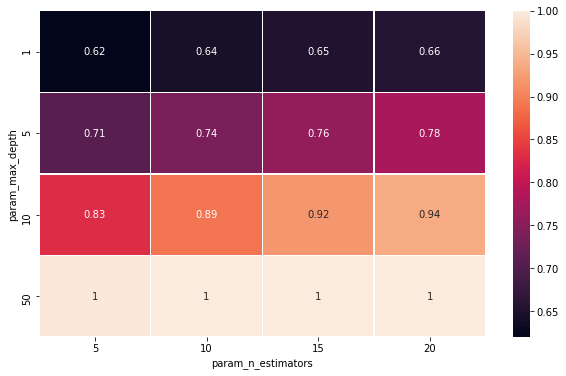

In [28]:
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_train_score', index='param_max_depth', columns='param_n_estimators') #https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
plt.figure(figsize=(10,6))
ax=sns.heatmap(pvt,annot=True,linewidths=.5)

#### Test

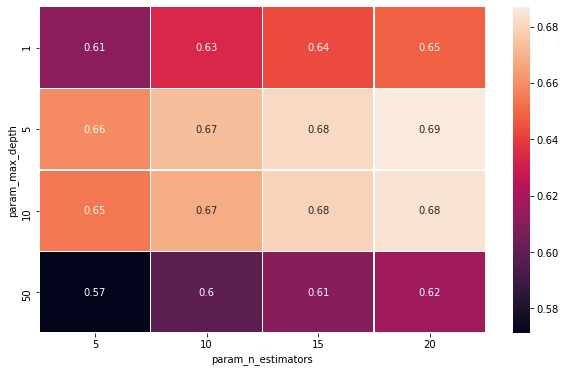

In [29]:
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_n_estimators') #https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
plt.figure(figsize=(10,6))
ax=sns.heatmap(pvt,annot=True,linewidths=.5)

### ROC : Train And Test Data

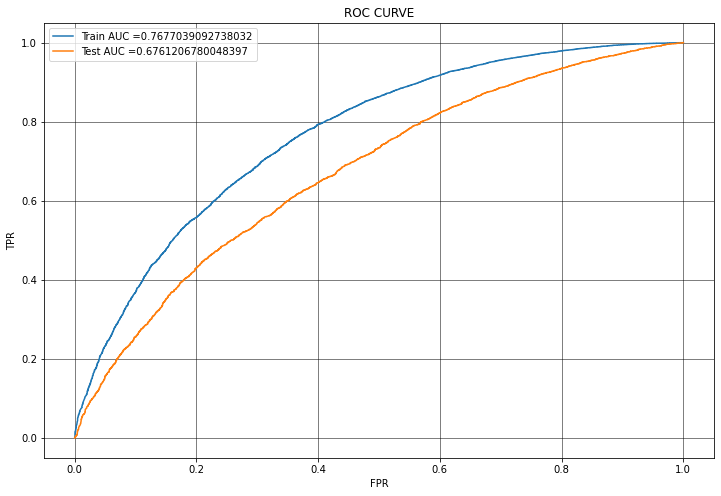

In [34]:
model = GradientBoostingClassifier(max_depth = best_max_depth,n_estimators = best_n_estimators,random_state = 0)
model.fit(X_tr_1,y_train)
y_tr_prob = clf.predict_proba(X_tr_1)[:,1]     # getting probability scores
y_te_prob = clf.predict_proba(X_te_1 )[:,1]

tr_fpr, tr_tpr, tr_thresh = roc_curve(y_train, y_tr_prob)       # getting fpr and tpr values
te_fpr, te_tpr, te_thresh = roc_curve(y_test, y_te_prob)

plt.figure(figsize=(12,8))
plt.plot(tr_fpr, tr_tpr, label="Train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(te_fpr, te_tpr, label="Test AUC ="+str(auc(te_fpr, te_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.grid(color='black',lw=0.5)

### Confusion Matrix

In [35]:
def calc_best_threshold(thresh, fpr, tpr):
    
    t = thresh[np.argmax(tpr*(1-fpr))]  # it will be maximum when fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3), "\n")
    return t

def calc_predictions(prob, thresh):
    predictions = []
    for p in prob:
        if p>=thresh:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.4857424171933649 for threshold 0.831 

Confusion Matrix of Train Data :
 [[ 3547  1818]
 [ 7464 20671]]


Text(0.5, 1.0, 'Confusion Matrix of Train Data')

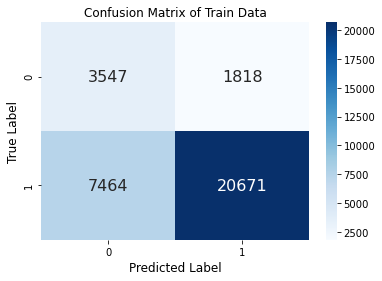

In [36]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

# For Train Data

best_t = calc_best_threshold(tr_thresh, tr_fpr, tr_tpr)
cm = metrics.confusion_matrix(y_train,calc_predictions(y_tr_prob, best_t))

print("Confusion Matrix of Train Data :\n",cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Confusion Matrix of Train Data',size=12)

the maximum value of tpr*(1-fpr) 0.39161129173386083 for threshold 0.844 

Confusion Matrix of Test Data :
 [[1675  967]
 [5298 8560]]


Text(0.5, 1.0, 'Confusion Matrix of Train Data')

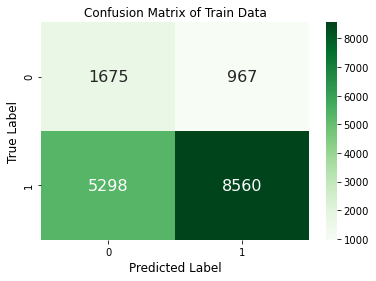

In [37]:
# For Test Data

best_t = calc_best_threshold(te_thresh, te_fpr, te_tpr)
cm = metrics.confusion_matrix(y_test,calc_predictions(y_te_prob, best_t))

print("Confusion Matrix of Test Data :\n",cm)
#print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='Greens',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Confusion Matrix of Train Data',size=12)

### DECISION TREE USING GRID SEARCH CV (SET - 2)

In [38]:

clf.fit(X_tr_2,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'n_estimators': [5, 10, 15, 20]},
             return_train_score=True, scoring='roc_auc')

In [40]:
tr_auc1 = clf.cv_results_['mean_train_score']
tr_auc_std1 = clf.cv_results_['std_train_score']
te_auc1 = clf.cv_results_['mean_test_score'] 
te_auc_std1 = clf.cv_results_['std_test_score']

best_max_depth1 = clf.best_params_["max_depth"]
best_n_estimators1 = clf.best_params_["n_estimators"]

print('Best score for set 1: ',clf.best_score_)
print('Best max_depth for set 1: ',best_max_depth1)
print('Best min_samples_split for set 1: ',best_n_estimators1)

Best score for set 1:  0.6371303747690995
Best max_depth for set 1:  5
Best min_samples_split for set 1:  20


### Hyperparameter v/s Auc

#### Train

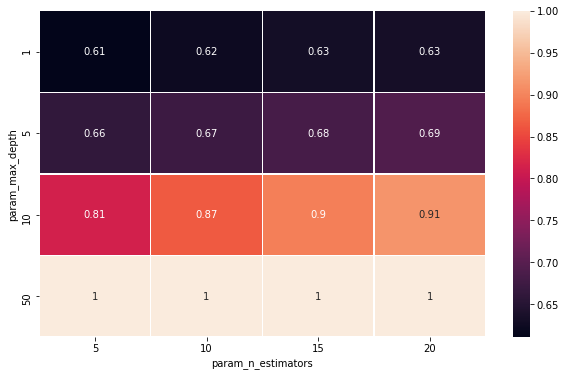

In [42]:
# reference - https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search

import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_train_score', index='param_max_depth', columns='param_n_estimators')
plt.figure(figsize=(10,6))
ax=sns.heatmap(pvt,annot=True,linewidths=.5)

#### Test

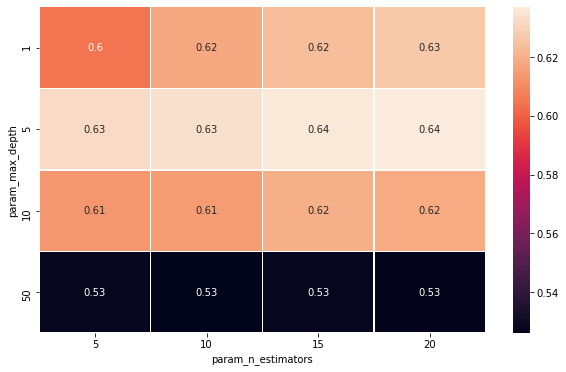

In [43]:
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_n_estimators')
plt.figure(figsize=(10,6))
ax=sns.heatmap(pvt,annot=True,linewidths=.5)

### ROC : Train And Test Data

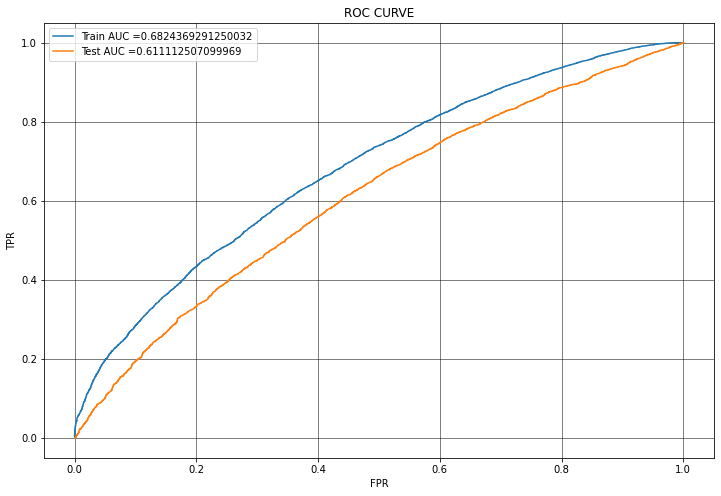

In [45]:
model1 = GradientBoostingClassifier(max_depth = best_max_depth1, n_estimators = best_n_estimators1, random_state = 0)
model1.fit(X_tr_2,y_train)
y_tr_prob = clf.predict_proba(X_tr_2)[:,1]     # getting probability scores
y_te_prob = clf.predict_proba(X_te_2)[:,1]

tr_fpr, tr_tpr, tr_thresh = roc_curve(y_train, y_tr_prob)       # getting fpr and tpr values
te_fpr, te_tpr, te_thresh = roc_curve(y_test, y_te_prob)

plt.figure(figsize=(12,8))
plt.plot(tr_fpr, tr_tpr, label="Train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(te_fpr, te_tpr, label="Test AUC ="+str(auc(te_fpr, te_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.grid(color='black',lw=0.5)

### Confusion Matrix

the maximum value of tpr*(1-fpr) 0.3941302444229833 for threshold 0.837 

Confusion Matrix of Train Data :
 [[ 3391  1974]
 [10591 17544]]


Text(0.5, 1.0, 'Confusion Matrix of Train Data')

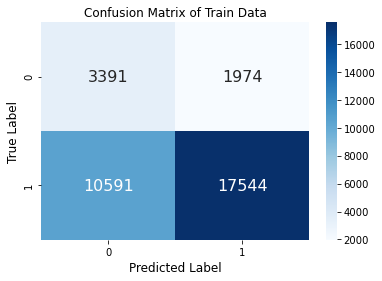

In [46]:
# For Train Data

best_t = calc_best_threshold(tr_thresh, tr_fpr, tr_tpr)
cm = metrics.confusion_matrix(y_train,calc_predictions(y_tr_prob, best_t))

print("Confusion Matrix of Train Data :\n",cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Confusion Matrix of Train Data',size=12)

the maximum value of tpr*(1-fpr) 0.3393891967287101 for threshold 0.838 

Confusion Matrix of Test Data :
 [[1477 1165]
 [5445 8413]]


Text(0.5, 1.0, 'Confusion Matrix of Train Data')

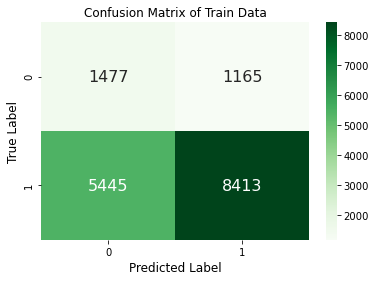

In [47]:
# For Test Data

best_t = calc_best_threshold(te_thresh, te_fpr, te_tpr)
cm = metrics.confusion_matrix(y_test,calc_predictions(y_te_prob, best_t))

print("Confusion Matrix of Test Data :\n",cm)
#print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='Greens',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Confusion Matrix of Train Data',size=12)

<h1>3. Summary</h1>


In [50]:
 # http://zetcode.com/python/prettytable/

from prettytable import PrettyTable
from prettytable import ALL as ALL

t = PrettyTable(hrules=ALL)
t.field_names = [ "S.No.","Vectorizer", "Model", "Hyper Parameter", "Test-AUC"]
t.add_row([1,"TFIDF", "GradientBoostingClassifier", "max_depth =5 , n_estimators=20", 0.687])
t.add_row([2,"TFIDF W2V", "GradientBoostingClassifier"," max_depth =5 , n_estimators=20", 0.637])
print(t)

+-------+------------+----------------------------+---------------------------------+----------+
| S.No. | Vectorizer |           Model            |         Hyper Parameter         | Test-AUC |
+-------+------------+----------------------------+---------------------------------+----------+
|   1   |   TFIDF    | GradientBoostingClassifier |  max_depth =5 , n_estimators=20 |  0.687   |
+-------+------------+----------------------------+---------------------------------+----------+
|   2   | TFIDF W2V  | GradientBoostingClassifier |  max_depth =5 , n_estimators=20 |  0.637   |
+-------+------------+----------------------------+---------------------------------+----------+
